# Serve Model Composition 

© 2019-2022, Anyscale. All Rights Reserved

📖 [Back to Table of Contents](./ex_00_tutorial_overview.ipynb)<br>
➡ [Next notebook](./ex_05_dev_to_prod.ipynb) <br>
⬅️ [Previous notebook](./ex_02_ray_serve_fastapi.ipynb) <br>

<img src="images/PatternsMLProduction.png" width="70%" height="40%">

## Learning Objective:
In this tutorial, you will learn how to:

 * compose models together. 
 * scale each model independently

## Background and Motivation

You are working for online furniture retailer called ServeCo. Each piece of furniture that ServeCo sells has a list of reviews from previous indivduals who have purchased that furniture. ServeCo believes that the order in which reviews are displayed on their website has a big impact on how many people purchase the furniture -- more positive reviews yield more purchases.

Your goal is:
1. Rank the reviews by sentiment
2. Improve the ranking over time

In this tutorial, we will show you how to use Serve Inference Graph to solve this problem. We will use a HuggingFace 🤗 sentiment model to sort the reviews, try an ensemble model to improve performance, and finally use A/B testing to measure the improvement.
 
 <img src="images/sentiment_analysis.jpeg" width="70%" height="40%">

# Setup

In [1]:
# Library imports
from typing import List, Tuple
import warnings
import os
import asyncio
import logging

In [2]:
# Ray imports
import ray
from ray import serve

In [ ]:
# Transformer model imports
from transformers import TranslationPipeline, TextClassificationPipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification

In [ ]:
# Start ray
if ray.is_initialized:
    ray.shutdown()
ray.init(logging_level=logging.ERROR)

In [5]:
# Environment setup
warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

# Example 1: Sort reviews by sentiment

Here are some reviews about a sofa on our ecommerce website. We want to sort these reviews by how positive they are!

In [6]:
reviews = [
    "AirCouch by ServeCo was fantastic! I loved it. Very small, perfect for my nephew who just moved into his place in SF.",
    "The couch came ridden with bugs. Do not purchase. Last purchase from ServCO. Their custmr support is unresponsive and no return policy",
    "AirCouch is pretty underwhelming. I bought it because of the positive reviews on their website. It seems okay, but nothing special",
    "The 2018 edition of AirCouch was better than the 2022. Still, the 2022 beats out SparkCouch",
    "this review has been removed",
    "This couch was trending on Spreddit... bought it 6 months ago and never looked back. Second purchase from ServeCo, they always deliver reliable couches."
]

## Define the Sentiment Deployment

Let's define a sentiment deployment that runs a hugging face sequence model.

**On Initialization**: It accepts a hugging face sequence model name, and initializes it

**On execution** It accepts a review, and returns its ranking

The higher the score, the more positive the review.

In [7]:

@serve.deployment
class RankingModel:
    def __init__(self, model_name: str) -> None:
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=128)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.pipeline = TextClassificationPipeline(model=self.model, tokenizer=self.tokenizer, task="sentiment-analysis")
    
    def rank(self, review: str) -> float:
        # Label is either "POSITIVE" or "NEGATIVE"    
        label = self.pipeline(review)[0]['label']
        
        # Score gives the model's confidence
        score = self.pipeline(review)[0]['score']
        
        # Combine the label and the score into a ranking  
        multiplier = 1 if label == "POSITIVE" else -1
        ranking = score * multiplier
        return ranking


## Define the Sorting Deployment

In [8]:
from pydantic import BaseModel

# Define a response type using Pydantic
class SortReviewsResponse(BaseModel):
    reviews: List[str]
    ranks: List[str]
    
async def parallel(*awaitables):
    """Run multiple Serve requests in parallel"""
    refs = await asyncio.gather(
        *awaitables
    )
    return await asyncio.gather(
        *refs
    )

@serve.deployment
class SortReviews:
    def __init__(self, ranking_model):
        self.ranking_model = ranking_model
    
    async def sort(self, reviews: List[str]) -> Tuple[float, str]:
        
        # Get sentiment for each review in parallel                 
        ranks = await parallel(
            *(
                self.ranking_model.rank.remote(review)
                for review in reviews
            )
        )

        # Sort the reviews by descending order of rank 
        sorted_ranks, sorted_reviews = zip(*sorted(zip(ranks, reviews), reverse=True))
        
        # Return the response
        return SortReviewsResponse(ranks=sorted_ranks, reviews=sorted_reviews)


## Deploy

Let's deploy! If you recall, `Deployment.bind()` lazily executes the constructor of the deployment, and returns a lazy handle to the deployment. The constructor
is only actually executed when we call `serve.run()` on the lazy handle. 

The idea behind model composition is simple -- we can pass lazy handles as constructor arguments into other deployments! The lazy handle will be populated with a live handle when the inference graph is deployed.

In [9]:
baseline_model_name = "distilbert-base-uncased"

# Lazily construct the RankingModel
rank_lazy_handle = RankingModel.bind(baseline_model_name)

# Pass the ranking model lazy handle into the Sort Deployment
sort_lazy_handle = SortReviews.bind(rank_lazy_handle)

# Run
sort_live_handle = serve.run(sort_lazy_handle)

That's it! Our Inference Graph should be live. Let's visualize it and query it.

## Visualize the Graph

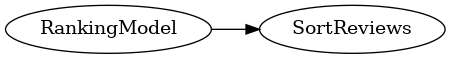

In [10]:
from ray.dag.vis_utils import plot

plot(sort_lazy_handle)

As you can see, the `RankingModel` is accessible from the `SortReviews` deployment.

## Query the pipeline

It's time to query the Inference Graph. We can query Serve deployment using either REST, or the ServeHandle API. For simplicity, we will use the ServeHandle API to query.

In [11]:
baseline_results = await sort_live_handle.sort.remote(reviews)
print(baseline_results.json(indent=2))

{
  "reviews": [
    "this review has been removed",
    "The couch came ridden with bugs. Do not purchase. Last purchase from ServCO. Their custmr support is unresponsive and no return policy",
    "AirCouch by ServeCo was fantastic! I loved it. Very small, perfect for my nephew who just moved into his place in SF.",
    "AirCouch is pretty underwhelming. I bought it because of the positive reviews on their website. It seems okay, but nothing special",
    "This couch was trending on Spreddit... bought it 6 months ago and never looked back. Second purchase from ServeCo, they always deliver reliable couches.",
    "The 2018 edition of AirCouch was better than the 2022. Still, the 2022 beats out SparkCouch"
  ],
  "ranks": [
    "-0.5050943493843079",
    "-0.5169469714164734",
    "-0.5174823999404907",
    "-0.5203433036804199",
    "-0.52256178855896",
    "-0.5467154383659363"
  ]
}


Great! We have successfully deployed our ReviewRanking pipeline. ServeCo can now display these ranked reviews on its website. Unfortunately, this ranking does not seem to be very good... 

# Example 2: Ensemble Sentiment Models

ServeCo management has decided that we need to improve the ranking. After some thought, we decide that we can use an **ensemble** of different sentiment models to get a better sentiment prediction. 

## Problem Statement
1. Ensemble the existing baseline model with a new experimental model
2. Average the rank predicted by each model to get the final rank


## Define the Ensemble
For simplicity, we will start with a simple average of rank produced by the models in our Ensemble. 

Notice that the `Ensemble` deployment is generic and reusable. It accepts any number of models, runs them in parallel, and then averages the result. 

In [12]:
@serve.deployment
class Ensemble:
    """Average the rank of several models"""
    def __init__(self, *models) -> None:
        self.models = models

    async def rank(self, review: str) -> float:
        # Get the rank of ensembled models in parallel     
        ranks = await parallel(
            *(model.rank.remote(review) for model in self.models)
        )
        
        # Return the average of the two models    
        return sum(ranks) / len(ranks)

## Deploy the Ensemble

The deploy step is going to be a little bit more complicated now -- we need to pass both the baseline and the experimental model into the ensemble, and then pass the ensemble into the sorter.

In [13]:
experimental_model_name = "distilbert-base-uncased-finetuned-sst-2-english"

# Baseline model
baseline_lazy_handle = RankingModel.bind(baseline_model_name)

# Experimental model
experimental_lazy_handle = RankingModel.bind(experimental_model_name)

# Ensemble model
ensemble_lazy_handle = Ensemble.bind(baseline_lazy_handle, experimental_lazy_handle)

# Sort
sorted_ensemble_lazy_handle = SortReviews.bind(ensemble_lazy_handle)

# Deploy
sorted_ensemble_live_handle = serve.run(sorted_ensemble_lazy_handle)

## Visualize the Ensemble

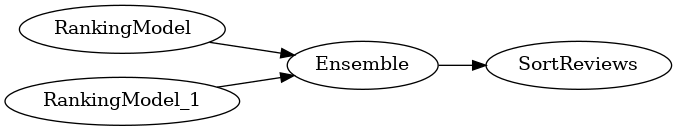

In [14]:
plot(sorted_ensemble_lazy_handle)

The pipeline is getting more complex! We have 2 Ranking models that feed into the Ensemble, which feeds into the Sorter.

## Sort reviews using the ensemble model

In [15]:
ensemble_results = await sorted_ensemble_live_handle.sort.remote(reviews)


# Compare ensemble results to baseline results
print(baseline_results.json(indent=2))
print(ensemble_results.json(indent=2))

{
  "reviews": [
    "this review has been removed",
    "The couch came ridden with bugs. Do not purchase. Last purchase from ServCO. Their custmr support is unresponsive and no return policy",
    "AirCouch by ServeCo was fantastic! I loved it. Very small, perfect for my nephew who just moved into his place in SF.",
    "AirCouch is pretty underwhelming. I bought it because of the positive reviews on their website. It seems okay, but nothing special",
    "This couch was trending on Spreddit... bought it 6 months ago and never looked back. Second purchase from ServeCo, they always deliver reliable couches.",
    "The 2018 edition of AirCouch was better than the 2022. Still, the 2022 beats out SparkCouch"
  ],
  "ranks": [
    "-0.5050943493843079",
    "-0.5169469714164734",
    "-0.5174823999404907",
    "-0.5203433036804199",
    "-0.52256178855896",
    "-0.5467154383659363"
  ]
}
{
  "reviews": [
    "The 2018 edition of AirCouch was better than the 2022. Still, the 2022 beats ou

Much better! The reviews at the top seem more positive than the ones at the bottom. Great job!

# Example 3: A/B Testing

ServeCo management is happy with the Ensemble, but wants us to show definitively that it is better than the Baseline model. 

One way to do this is to **A/B Test** the Baseline model against the Ensemble model. In this example, we will show how A/B testing is easy in Serve!

## What is A/B testing

To A/B test our models, we need to do the following:
1. Randomly assign users to 2 groups (Group A and Group B)
2. Show members of A rankings based on the Baseline
3. Show members of B rankings based on the Ensemble
4. If group B is more satisfied than Group A, then the Ensemble is working!

This example is intended to give you a taste of how Serve makes A/B testing easy. We will skip over the statistical details required in practice to conduct an A/B test, to instead focus on building the infrastructure required to gather the data (steps 1-3).

## Defining an A/B test deployment

Let's start by defining an A/B testing deployment. 

In [16]:
@serve.deployment
class ABTest:
    def __init__(self, model_a, model_b):
        self.model_a = model_a
        self.model_b = model_b
    
    def group(self, user_id: int):
        """Randomely assign the user to a group"""
        return "A" if user_id % 2 == 0 else "B"
    
        
    async def rank(self, review: str, user_id: int) -> float: 
        """Get the sentiment for a review"""
        
        is_group_a = self.group(user_id) == "A"
        model = self.model_a if is_group_a else self.model_b
        ref = await model.rank.remote(review)
        return await ref
        

Since the ABTest deployment has a slightly different API than the SentimentModel (it also accepts a user_id), we need to
update the SortReviews deployment.

In [17]:
class SortReviewsResponse(BaseModel):
    group: str
    reviews: List[str]
    ranks: List[str]

@serve.deployment
class SortReviews:
    def __init__(self, ranking_model):
        self.ranking_model = ranking_model
    
    async def sort_reviews(self, reviews: List[str], user_id: int) -> Tuple[float, str]:

        # Get the group of the user in the AB test
        group_ref = await self.ranking_model.group.remote(user_id)

        
        # Get sentiment for each review in parallel                 
        ranks = await parallel(
            *(
                self.ranking_model.rank.remote(review, user_id)
                for review in reviews
            )
        )

        # Sort the reviews by their rank
        sorted_ranks, sorted_reviews = zip(*sorted(zip(ranks, reviews), reverse=True))
        
        return SortReviewsResponse(group=await group_ref, ranks=sorted_ranks, reviews=sorted_reviews)

## Deploy

Deploying our inference graph is a little bit more tricky this time around. We will scale the baseline model to have 2 replicas instead of one -- 
one replica will handle traffic for group A (which directly hits the Baseline), and the other will handle traffic for group B (which hits the Ensemble model).

In [18]:
# Model 1
baseline_lazy_handle = RankingModel.options(num_replicas=2).bind(baseline_model_name)

# Model 2 -- same model with different weights
experimental_lazy_handle = RankingModel.bind(experimental_model_name)

# Ensemble model
ensemble_lazy_handle = Ensemble.bind(baseline_lazy_handle, experimental_lazy_handle)

# AB Test deployment
ab_test_lazy_handle = ABTest.bind(baseline_lazy_handle, ensemble_lazy_handle)

# Sort the reviews
sorted_ensemble_lazy_handle = SortReviews.bind(ab_test_lazy_handle)

# Run!
ab_test_live_handle = serve.run(sorted_ensemble_lazy_handle)

## Visualize

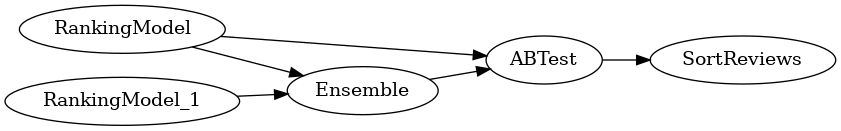

In [19]:
plot(sorted_ensemble_lazy_handle)

## Query

Let's query the inference graph with 2 different user ids and make sure we are getting the results corresponding to the Baseline Model and the Ensemble Model.

In [20]:
sorted_reviews_a = await ab_test_live_handle.sort_reviews.remote(reviews, user_id=0)
sorted_reviews_b = await ab_test_live_handle.sort_reviews.remote(reviews, user_id=1)

# Compare
print(sorted_reviews_a.json(indent=2))
print(sorted_reviews_b.json(indent=2))

{
  "group": "A",
  "reviews": [
    "This couch was trending on Spreddit... bought it 6 months ago and never looked back. Second purchase from ServeCo, they always deliver reliable couches.",
    "The 2018 edition of AirCouch was better than the 2022. Still, the 2022 beats out SparkCouch",
    "AirCouch by ServeCo was fantastic! I loved it. Very small, perfect for my nephew who just moved into his place in SF.",
    "The couch came ridden with bugs. Do not purchase. Last purchase from ServCO. Their custmr support is unresponsive and no return policy",
    "AirCouch is pretty underwhelming. I bought it because of the positive reviews on their website. It seems okay, but nothing special",
    "this review has been removed"
  ],
  "ranks": [
    "-0.534937858581543",
    "-0.5407721400260925",
    "-0.541819155216217",
    "-0.5647710561752319",
    "-0.5761180520057678",
    "-0.5762368440628052"
  ]
}
{
  "group": "B",
  "reviews": [
    "AirCouch by ServeCo was fantastic! I loved it. 

# Conclusion

Serve has a powerful API for composing arbitrarily complex Inference Graphs. You can compose hundreds of models into a graph, and scale it across hundreds of nodes. Hopefully this tutorial gave you a taste for what is possible in Serve.

In [21]:
ray.shutdown()

### Exercise

1. Add more reviews with different sentiments to see what happens
2. Query the pipeline using HTTP. Hint -- you will have to add an HTTP request handler. See the [Fast API Module](ex_02_ray_serve_fastapi.ipynb) for an example.
3. Measure the QPS of the pipeline. Look at [Module 1](ex_01_model_serving_challenges.ipynb) to see an example.


### Homework

1. Use a different model in your pipeline


📖 [Back to Table of Contents](./ex_00_tutorial_overview.ipynb)<br>
➡ [Next notebook](./ex_04_inference_graphs.ipynb) <br>
⬅️ [Previous notebook](./ex_02_ray_serve_fastapi.ipynb) <br>